In [1]:
import os, sys
import tqdm
import torch
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

import yaml

from numpy import random

In [2]:
is_cuda = torch.cuda.is_available()
device = torch.device(torch.cuda.current_device()) if is_cuda else torch.device("cpu")

if is_cuda:
    torch.backends.cudnn.benchmark = True
    #torch.backends.cudnn.deterministic = True

In [3]:
import importlib

In [4]:
from holodecml.datasets import LoadHolograms

In [5]:
# importlib.reload(holodecml.datasets)

In [6]:
with open("/glade/work/schreck/repos/HOLO/dev/holodec-ml/results/manopt/model.yml") as cf:
    conf = yaml.load(cf, Loader=yaml.FullLoader)

lookahead = 5 #int(conf["data"]["lookahead"])
conf["model"]["in_channels"] = 2 * (lookahead + 1)

n_bins = 100 #int(conf["data"]["n_bins"])
tile_size = int(conf["data"]["tile_size"])
step_size = int(conf["data"]["step_size"])

train_dataset = LoadHolograms(
    "/glade/p/cisl/aiml/ai4ess_hackathon/holodec/synthetic_holograms_500particle_gamma_4872x3248_training.nc", 
    shuffle = False, 
    device = device, 
    n_bins = n_bins, 
    # transform = LoadTransformations(conf["transforms"]["training"]), 
    lookahead = lookahead, 
    tile_size = tile_size, 
    step_size = step_size,
    output_lst = [torch.abs,torch.angle],
    deweight = 1e-6  # amount to deweight empty pixels in the loss function (through the weight mask)
)


In [7]:
# random_integer = random.randint(0, train_dataset.__len__())
random_integer = 9320
print("Id", random_integer)
x, y1, y2, y3 = train_dataset.__getitem__(random_integer)
print(x.shape, y1.shape, y2.shape)
print("Particl Mask sum", y1.sum())
print("Depth Mask sum", y2.sum())
print("Weight Mask sum", y3.sum())

Id 9320
torch.Size([1, 10, 4896, 3264]) torch.Size([4896, 3264]) torch.Size([4896, 3264])
Particl Mask sum tensor(5904., dtype=torch.float64)
Depth Mask sum tensor(5528062.2461, dtype=torch.float64)
Weight Mask sum tensor(23497.8008, dtype=torch.float64)


Text(0.5, 1.0, 'Weight Mask')

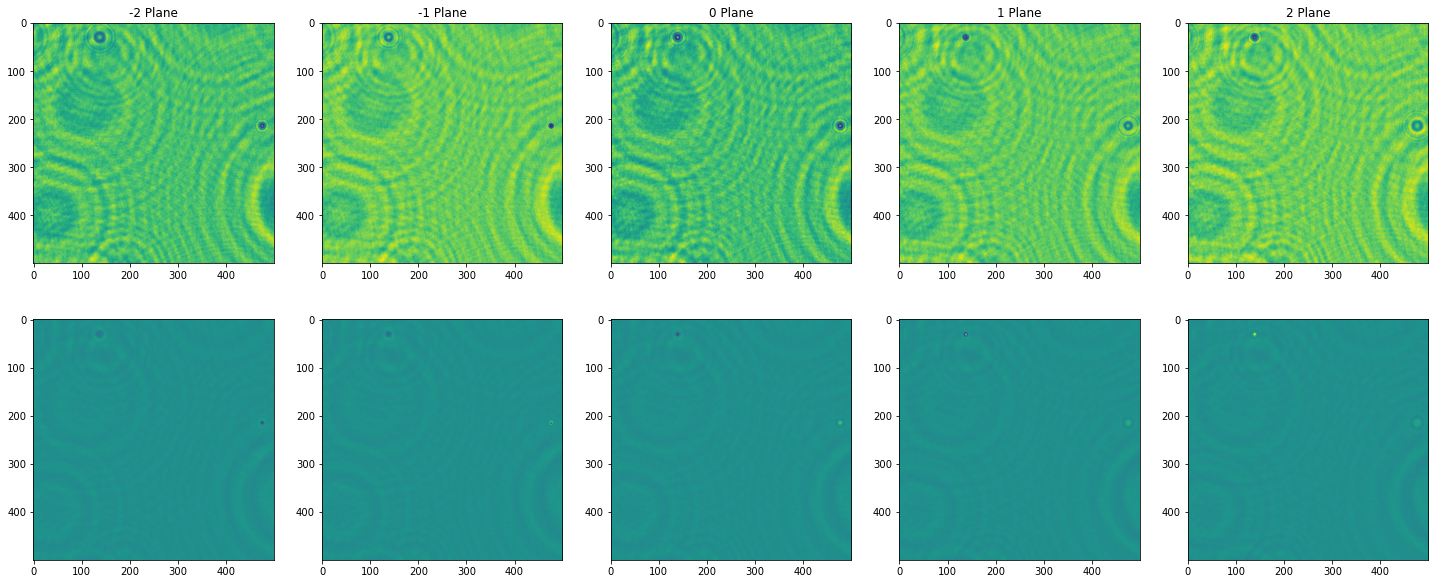

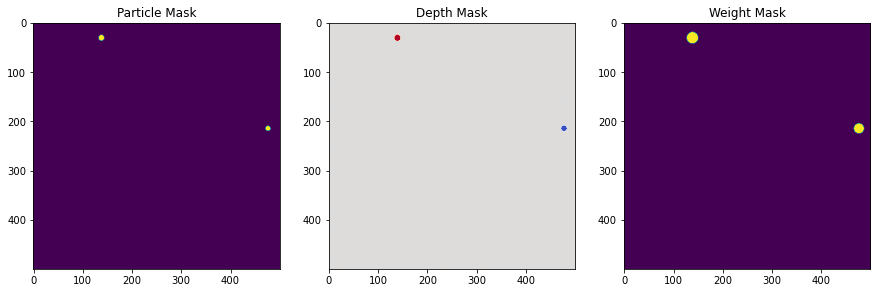

In [8]:
fig,ax_lst = plt.subplots(2,lookahead,figsize=(5*lookahead,10))

rw_slc = slice(1500, 2000)
cl_slc = slice(1500, 2000)


# plot the multi plane stack
for pln_idx in range(lookahead):
    ax = ax_lst[0,pln_idx]
    ax.imshow(x[0,pln_idx,rw_slc,cl_slc].detach().cpu().numpy().T)
    ax.set_title(f"{pln_idx-train_dataset.z_bck_idx} Plane")
    ax = ax_lst[1,pln_idx]
    ax.imshow(x[0,pln_idx+lookahead,rw_slc,cl_slc].detach().cpu().numpy().T,vmin=-np.pi,vmax=np.pi)

# plot the mask outputs
fig,ax_lst = plt.subplots(1,3,figsize=(15,5))
ax = ax_lst[0]
ax.imshow(y1[rw_slc,cl_slc].detach().cpu().numpy().T,vmin=0,vmax=1)
ax.set_title("Particle Mask")

ax = ax_lst[1]
ax.imshow(y2[rw_slc,cl_slc].detach().cpu().numpy().T,vmin=-1000,vmax=1000,cmap='coolwarm')
ax.set_title("Depth Mask")

ax = ax_lst[2]
ax.imshow(y3[rw_slc,cl_slc].detach().cpu().numpy().T)
ax.set_title("Weight Mask")